# Creating a General Purpose Potential for Molecular Crystals - Part 7

This notebook is used to create a general purpose GAP potential for molecular crystals. The potential is built on PBE-D3 data from short PIMD simulations of 2238 different molecular crystals. Please note that it has a high (~150 GB) memory requirement to run fully.

In this part of the notebook: 
- More tests...

### Import modules, functions, and necessary raw data from parts 1, 2 and 3

In [2]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed, parallel_backend

import pickle
import numpy as np
from numpy.random import RandomState
random_state = RandomState(0)
from sklearn import linear_model
import skcosmo.feature_selection
#from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR, FPS
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize, callbacks, dump, load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time, sleep

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score, get_optimal_radial_basis_hypers
from rascal.utils.io import load_json, dump_json

In [3]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array('forces') 
        iat += len(frm)
    return frc

def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), disable = not progress_bar): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

def get_features_parallel(atoms_objects, bsize=1000, n_cores = 4):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        Do this in parallel
    '''
    blocks = []
    for iblk, blk in enumerate(range(0, len(atoms_objects), bsize)):
        blocks.append(atoms_objects[iblk*bsize:(iblk+1)*bsize])
    with parallel_backend(backend="loky"):
        results = Parallel(n_jobs=n_cores)(delayed(get_features)(frames, batch_size=10000, 
                                                                 progress_bar=False) for frames in blocks)

    return np.concatenate(results)

def predict_batched(frames, ml_model):
    man_pred = soap.transform(frames)
    return ml_model.predict(man_pred)

In [4]:
#Import raw data
train_set = np.load('raw_data/CSD-10k_train_set.npy', allow_pickle=True)
val_set = np.load('raw_data/CSD-10k_val_set.npy', allow_pickle=True)
test_set = np.load('raw_data/CSD-10k_test_set.npy', allow_pickle=True)
X_train = np.load('raw_data/X_train.npy') 
y_train = np.load('raw_data/y_train.npy')
X_val = np.load('raw_data/X_val.npy') 
y_val = np.load('raw_data/y_val.npy')
X_test = np.load('raw_data/X_test.npy') 
y_test = np.load('raw_data/y_test.npy')
X_train_fps = np.load('raw_data/X_train_fps.npy')
y_train_fps = np.load('raw_data/y_train_fps.npy')
fps_ids = np.load('raw_data/CSD-10k_train_set_FPS_ids.npy')
fps_dist = np.load('raw_data/CSD-10k_train_set_FPS_dist.npy')
with open('raw_data/mlr.pkl', 'rb') as mlr_file:
    mlr = pickle.load(mlr_file)
initial_train_set = np.load('raw_data/initial_train_set_4pc.npy', allow_pickle=True)
train_set_FPS = np.load('model_data/train_set_FPS.npy', allow_pickle=True)

### Compute necessary data and define SOAP

In [5]:
#Compute training, validation and testing data
#Get training data for the FPS-sorted training set
ytF = []
for ifrm, frm in enumerate(train_set_FPS):
    ytF.append(frm.info['energy'])
ytrain_FPS = np.array(ytF)

#Get true energies and forces for validation set
yvt = []
fvt = []

for frm in val_set:
    yvt.append(frm.info['energy'])
    fvt.append(frm.get_array('forces'))

yval_true = np.array(yvt)
fval_true = np.concatenate(fvt)

#Get true energies and forces for test set
ytt = []
ftt = []

for frm in test_set:
    ytt.append(frm.info['energy'])
    ftt.append(frm.get_array('forces'))

ytest_true = np.array(ytt)
ftest_true = np.concatenate(ftt)

#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

In [6]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

## Check variance of force predictions for direct and delta model

In part 5 of this notebook, I showed that the variance of forces of DFTB+ - PBE is about half that of PBE on its own. Simulations of succinic acid, benzene and glycine are unstable using the direct PBE potential, but stable using DFTB+ with the PBE0-MBD potential. I will therefore compare the variance of the predicted forces throughout the simulations.

Note that although I'm using the potential trained on PBE0-MBD, the results should still be comparable.

In [49]:
#Import frames 
compound = 'succinic_alpha'
direct = read('../genMD/PI_NVT_direct/'+compound+'/simulation.frc_00.xyz', ':')
delta = read('../genMD/PI_NVT_PBE0/'+compound+'/simulation.frc_00.xyz', ':')

In [50]:
#Get forces
direct_frcs = []
delta_frcs = []
for frm in direct:
    direct_frcs.extend(frm.get_positions())
for frm in delta:
    delta_frcs.extend(frm.get_positions())
direct_frcs = np.asarray(direct_frcs).flatten()
delta_frcs = np.asarray(delta_frcs).flatten()

In [51]:
#convert forces from atomic units to eV/angstrom
#note that this is not necessary for comparing variances, but may be useful to compare with other results later
#one a.u. of force is equal to 51.421 eV/angstrom
if np.var(direct_frcs) < 0.1:      #make sure that multiplication doesn't happen again if cell was already run
    direct_frcs = direct_frcs*51.421
if np.var(delta_frcs) < 0.1:
    delta_frcs = delta_frcs*51.421

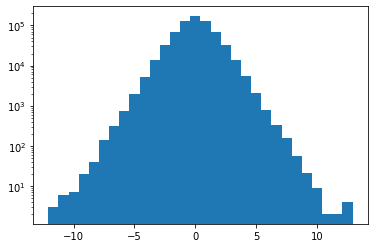

In [52]:
plt.hist(direct_frcs, bins = 30)
plt.yscale('log')

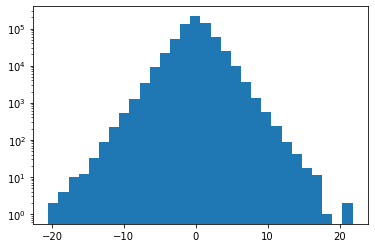

In [53]:
plt.hist(delta_frcs, bins = 30)
plt.yscale('log')